In [1]:
import open3d as o3d
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
QApp = QApplication([])
QWidget = QWidget()
import os
import pickle
import numpy as np

from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Load map

In [2]:
# Load ply map into open3d
world_file = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/daniel/Documents/master/maps/island_boy2.ply")[0]
if not os.path.isfile(world_file):
    raise FileNotFoundError("World file not found.")
world = o3d.io.read_triangle_mesh(world_file)
print("World loaded from file: ", world_file)
print("World has normals: ", world.has_triangle_normals(), "\nWorld has vertex normals: ", world.has_vertex_normals())
# Check if world triangles has normals
if not world.has_triangle_normals():
    print("Computing normals")
    # Compute normals
    world.compute_triangle_normals()
else:
    print("World has normals")

# Visualize world
o3d.visualization.draw_geometries([world])

World loaded from file:  /home/daniel/Documents/master/maps/island_boy2.ply
World has normals:  False 
World has vertex normals:  True
Computing normals


In [3]:
def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	print(len(data))

	orientations = []
	positions = []
	timesteps = []
	for msg in data:
		positions.append(msg[0])
		orientations.append(msg[1])
		timesteps.append(msg[2])


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict

def get_odom_data(dict, dict_key):
	orientations = []
	positions = []
	velocities = []
	ang_velocities = []
	timesteps = []
	for msg in dict[dict_key]:
		orientations.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]))
		positions.append(np.array([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z]))
		velocities.append(np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z]))
		ang_velocities.append(np.array([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z]))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	odom_dict = {"orientations" : orientations, "positions" : positions, "velocities" : velocities, "ang_velocities" : ang_velocities, "timesteps" : timesteps}
	return odom_dict

def get_twist_data(dict, dict_key):
	linear = []
	angular = []
	for msg in dict[dict_key]:
		linear.append(np.array([msg.linear.x, msg.linear.y, msg.linear.z]))
		angular.append(np.array([msg.angular.x, msg.angular.y, msg.angular.z]))
	twist_dict = {"linear" : linear, "angular" : angular}
	return twist_dict

# from rosbags.rosbag2 import Reader
# from rosbags.serde import deserialize_cdr
# # Load all messages on topic /wagon/base_link_pose_gt

# def load_from_bag(bag_file, topic):
#     gt_positions = []
#     gt_orientations = []
#     clock = []
#     with Reader(bag_file) as reader:
#         #for connection in reader.connections:
#             #print(connection.topic, connection.msgtype)
#         for connection, timestamp, rawdata in reader.messages():
#             if connection.topic == topic:
#                 msg = deserialize_cdr(rawdata, connection.msgtype)
#                 #print(msg.header.frame_id)
#                 #print(msg.pose.pose.position.x)
#                 gt_positions.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
#                 gt_orientations.append([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w])
#                 clock.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

#     return gt_positions, gt_orientations, clock
# Create lineset from positions
# Create lineset [[0,1], [1,2], [2,3], ...]
def create_lineset(positions, color):
    lines = []
    for i in range(len(positions)-1):
        lines.append([i, i+1])
    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(positions)
    lineset.lines = o3d.utility.Vector2iVector(lines)
    lineset.colors = o3d.utility.Vector3dVector([color for i in range(len(lines))])
    return lineset

In [4]:
file_path = QFileDialog.getOpenFileName(QWidget, 'full ekf', "/home/daniel/Documents/master/rosbags/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
    print("loaded full ekf", file_path)

    
base_gt = get_odom_data(data, "base_link_pose_gt")

base_ekf_full = get_odom_data(data, "odometry_ekf")

file_path = QFileDialog.getOpenFileName(QWidget, 'Single imu front', "/home/daniel/Documents/master/rosbags/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
    print("loaded single imu front", file_path)
   
base_ekf_single_imu = get_odom_data(data, "odometry_ekf")


file_path = QFileDialog.getOpenFileName(QWidget, 'imu rear', "/home/daniel/Documents/master/rosbags/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
    print("loaded single imu rear", file_path)
   
base_ekf_single_imu_rear = get_odom_data(data, "odometry_ekf")

file_path = QFileDialog.getOpenFileName(QWidget, 'odom only', "/home/daniel/Documents/master/rosbags/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
    print("loaded odom only", file_path)

   
base_ekf_odom = get_odom_data(data, "odometry_ekf")


loaded full ekf /home/daniel/Documents/master/rosbags/odom_test/full_ekf.pkl
loaded single imu front /home/daniel/Documents/master/rosbags/odom_test/imu_single.pkl
loaded single imu rear /home/daniel/Documents/master/rosbags/odom_test/single_imu_rear.pkl
loaded odom only /home/daniel/Documents/master/rosbags/odom_test/odom_only.pkl


In [5]:
gt_lineset = create_lineset(base_gt["positions"], [1,0,0])
ekf_full = create_lineset(base_ekf_full["positions"], [0,1,0])
ekf_single = create_lineset(base_ekf_single_imu["positions"], [0,0,1])
ekf_single_rear = create_lineset(base_ekf_single_imu_rear["positions"], [1,0,1])
ekf_odom = create_lineset(base_ekf_odom["positions"], [0,1,1])
#mapping_lineset = create_lineset(mapping_positions, [0,0,1])
# mapping_file = QFileDialog.getOpenFileName(QWidget, 'Open pkl file of mapping data', "/home/daniel/Documents/bags/island_boy_2_gt.pkl")[0]
# print("Mapping file: ", mapping_file)
# # Load mapping data pickle
# with open(mapping_file, "rb") as f:
#     mapping_list = pickle.load(f)
# mapping_lineset = create_lineset(mapping_list, [0,0,1])
# Visualize and add legend to the plot


o3d.visualization.draw_geometries([world, gt_lineset, ekf_full, ekf_single, ekf_odom])



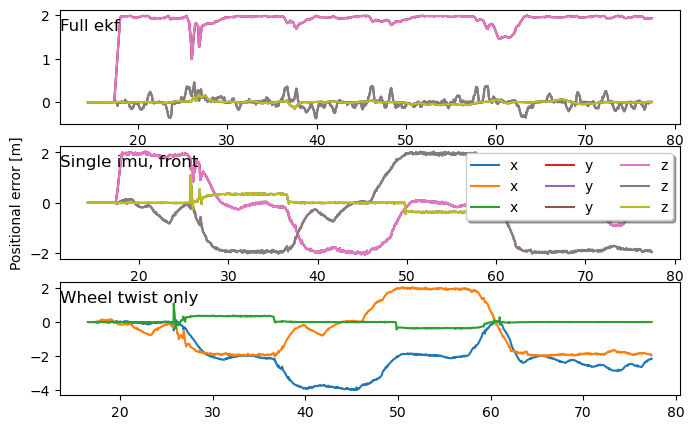

In [6]:
dist = np.empty((0,3))
angular_difference = []

base_ekf_full_pose = np.array(base_ekf_full["velocities"])
base_ekf_single_imu_pose = np.array(base_ekf_single_imu["velocities"])
base_ekf_odom_pose = np.array(base_ekf_odom["velocities"])

# base_ekf_full_pose[:,2] = base_ekf_full_pose[:,2] - 0.5

# base_ekf_single_imu_pose[:,2] = base_ekf_single_imu_pose[:,2] - 0.5
# base_ekf_odom_pose[:,2] = base_ekf_odom_pose[:,2] - 0.5
# base_ekf_dual_twist_pose[:,2] = base_ekf_dual_twist_pose[:,2] - 0.5

gt_positions = np.array(base_gt["velocities"])
# loc_positions = np.array(localization_dict["positions"])

for i, pos in enumerate(base_ekf_full_pose):

    
    # find closest timestep in gt 
    idx = np.argmin(np.abs(np.array(base_gt["timesteps"]) - base_ekf_full["timesteps"][i]))

    #print(gt_positions[idx] - pos)
    dist = np.vstack((dist, (gt_positions[idx] - pos)))
    # Calculate difference in roll, pitch and yaw between gt and localization
    # print(base_gt["orientations"][idx].as_euler('xyz', degrees=False), base_ekf_full["orientations"][i])
    gt_rpy = base_gt["orientations"][idx].as_euler('xyz', degrees=False)
    loc_rpy = base_ekf_full["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference = np.array(angular_difference)

dist_single = np.empty((0,3))

for i, pos in enumerate(base_ekf_single_imu_pose):
    idx = np.argmin(np.abs(np.array(base_gt["timesteps"]) - base_ekf_single_imu["timesteps"][i]))
    #print(gt_positions[idx] - pos)
    dist_single = np.vstack((dist_single, (gt_positions[idx] - pos)))

dist_odom = np.empty((0,3))

for i, pos in enumerate(base_ekf_odom_pose):
    idx = np.argmin(np.abs(np.array(base_gt["timesteps"]) - base_ekf_odom["timesteps"][i]))
    #print(gt_positions[idx] - pos)
    dist_odom = np.vstack((dist_odom, (gt_positions[idx] - pos)))


fig, ax = plt.subplots(3,1)

# Plot distance vs time 

ax[0].plot(base_ekf_full["timesteps"], base_ekf_full["velocities"], label="x")
ax[0].plot(base_ekf_full["timesteps"], base_ekf_full["velocities"], label="y")
ax[0].plot(base_ekf_full["timesteps"], base_ekf_full["velocities"], label="z")
# Add title to the plot
ax[0].set_title("Full ekf", y=0.75, loc="left")

ax[1].plot(base_gt["timesteps"], base_gt["velocities"], label="x")
ax[1].plot(base_gt["timesteps"], base_gt["velocities"], label="y")
ax[1].plot(base_gt["timesteps"], base_gt["velocities"], label="z")
ax[1].set_title("Single imu, front", loc="left", y=0.75)

# ax[0].plot(base_ekf_full["timesteps"], dist[:,0], label="x")
# ax[0].plot(base_ekf_full["timesteps"], dist[:,1], label="y")
# ax[0].plot(base_ekf_full["timesteps"], dist[:,2], label="z")
# # Add title to the plot
# ax[0].set_title("Full ekf", y=0.75, loc="left")

# ax[1].plot(base_ekf_single_imu["timesteps"], dist_single[:,0], label="x")
# ax[1].plot(base_ekf_single_imu["timesteps"], dist_single[:,1], label="y")
# ax[1].plot(base_ekf_single_imu["timesteps"], dist_single[:,2], label="z")
# ax[1].set_title("Single imu, front", loc="left", y=0.75)


ax[2].plot(base_ekf_odom["timesteps"], dist_odom[:,0], label="x")
ax[2].plot(base_ekf_odom["timesteps"], dist_odom[:,1], label="y")
ax[2].plot(base_ekf_odom["timesteps"], dist_odom[:,2], label="z")
ax[2].set_title("Wheel twist only", y=0.75, loc="left")



# Set width and height of plot
width = 8
height = 5
fig.set_figwidth(width)
fig.set_figheight(height)

# # Plot angular difference vs time
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,0], label="roll")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,1], label="pitch")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,2], label="yaw")

# Vertically align y labels on plot 0 and 1
fig.align_ylabels()

# Place legend horizontally
ax[1].legend(loc='upper right', ncol=3, fancybox=True, shadow=True)

ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Positional error [m]")

plt.show()



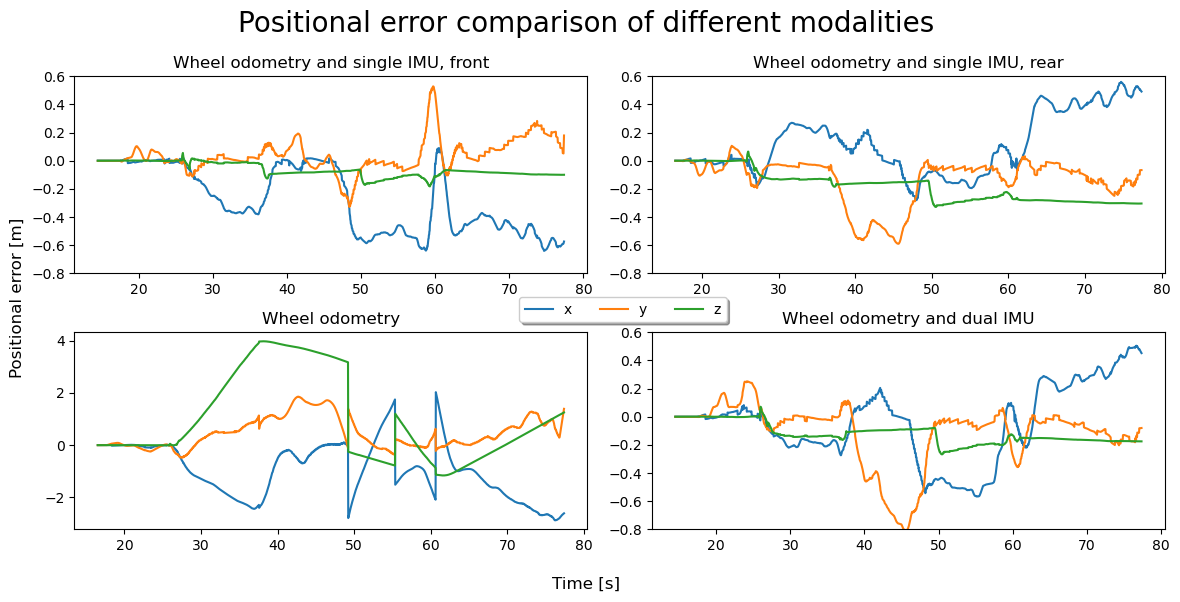

In [7]:

angular_difference = []

base_ekf_full_pose = np.array(base_ekf_full["positions"])
base_ekf_single_imu_pose = np.array(base_ekf_single_imu["positions"])
base_ekf_odom_pose = np.array(base_ekf_odom["positions"])
base_ekf_single_imu_rear_pose = np.array(base_ekf_single_imu_rear["positions"])

base_ekf_full_pose[:,2] = base_ekf_full_pose[:,2] - 0.5

base_ekf_single_imu_pose[:,2] = base_ekf_single_imu_pose[:,2] - 0.5
base_ekf_single_imu_rear_pose[:,2] = base_ekf_single_imu_rear_pose[:,2] - 0.5
base_ekf_odom_pose[:,2] = base_ekf_odom_pose[:,2] - 0.5

gt_positions = np.array(base_gt["positions"])
# loc_positions = np.array(localization_dict["positions"])
dist = np.empty((0,3))
for i, pos in enumerate(base_ekf_full_pose):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    #print(gt_positions[idx] - pos)
    dist = np.vstack((dist, gt_positions[idx] - pos))
    # Calculate difference in roll, pitch and yaw between gt and localization
    # print(base_gt["orientations"][idx].as_euler('xyz', degrees=False), base_ekf_full["orientations"][i])
    gt_rpy = base_gt["orientations"][idx].as_euler('xyz', degrees=False)
    loc_rpy = base_ekf_full["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference = np.array(angular_difference)

dist_single = np.empty((0,3))

for i, pos in enumerate(base_ekf_single_imu_pose):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    #print(gt_positions[idx] - pos)
    dist_single = np.vstack((dist_single, gt_positions[idx] - pos))

dist_single_rear = np.empty((0,3))

for i, pos in enumerate(base_ekf_single_imu_rear_pose):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    #print(gt_positions[idx] - pos)
    dist_single_rear = np.vstack((dist_single_rear, gt_positions[idx] - pos))

dist_odom = np.empty((0,3))

for i, pos in enumerate(base_ekf_odom_pose):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    #print(gt_positions[idx] - pos)
    dist_odom = np.vstack((dist_odom, gt_positions[idx] - pos))


fig, ax = plt.subplots(2,2)

# Plot distance vs time 

ax[1,1].plot(base_ekf_full["timesteps"], dist[:,0], label="x")
ax[1,1].plot(base_ekf_full["timesteps"], dist[:,1], label="y")
ax[1,1].plot(base_ekf_full["timesteps"], dist[:,2], label="z")
ax[1,1].set_title("Wheel odometry and dual IMU", loc="center")
ax[1,1].set_ylim([-0.8, 0.6])

ax[0,0].plot(base_ekf_single_imu["timesteps"], dist_single[:,0], label="x")
ax[0,0].plot(base_ekf_single_imu["timesteps"], dist_single[:,1], label="y")
ax[0,0].plot(base_ekf_single_imu["timesteps"], dist_single[:,2], label="z")
ax[0,0].set_title("Wheel odometry and single IMU, front", loc="center")
ax[0,0].set_ylim([-0.8, 0.6])


ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], dist_single_rear[:,0], label="x")
ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], dist_single_rear[:,1], label="y")
ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], dist_single_rear[:,2], label="z")
ax[0,1].set_title("Wheel odometry and single IMU, rear", loc="center")
ax[0,1].set_ylim([-0.8, 0.6])

ax[1,0].plot(base_ekf_odom["timesteps"], dist_odom[:,0], label="x")
ax[1,0].plot(base_ekf_odom["timesteps"], dist_odom[:,1], label="y")
ax[1,0].plot(base_ekf_odom["timesteps"], dist_odom[:,2], label="z")
ax[1,0].set_title("Wheel odometry", loc="center")


# Set width and height of plot
width = 12
height = 6
fig.set_figwidth(width)
fig.set_figheight(height)

# # Plot angular difference vs time
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,0], label="roll")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,1], label="pitch")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,2], label="yaw")

# Vertically align y labels on plot 0 and 1
# fig.align_ylabels()

# Place legend horizontally
# ax[0,0].legend(, ncol=3, fancybox=True, shadow=True)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.44, 0.465), ncol=3, fancybox=True, shadow=True)

fig.supylabel("Positional error [m]")
fig.subplots_adjust(hspace=0.2, wspace=0.2)
fig.supxlabel("Time [s]")
fig.suptitle("Positional error comparison of different modalities", fontsize=20)

# change margin between supxlabel, supylabel and subplots
plt.tight_layout()

plt.savefig("/home/daniel/Documents/master/billeder/odom_ekf_pos_error.png", dpi=300)

plt.show()


RMSE full ekf:  [0.27324379 0.24969411 0.13989123]
RMSE single imu:  [0.35848154 0.12079182 0.08023311]
RMSE single imu rear:  [0.24253868 0.20883712 0.21262761]
RMSE wheel twist:  [1.3953867  0.74059531 1.91947646]
Mean full ekf:  [-0.04359396 -0.11357649 -0.12010503]
Mean single imu:  [-0.27365367  0.03725319 -0.06396276]
Mean single imu rear:  [ 0.11630271 -0.1323578  -0.18355049]
Mean wheel twist:  [-0.94466362  0.45650145  0.97665541]


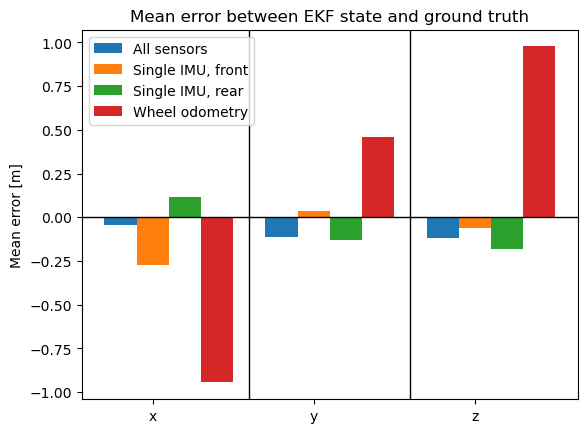

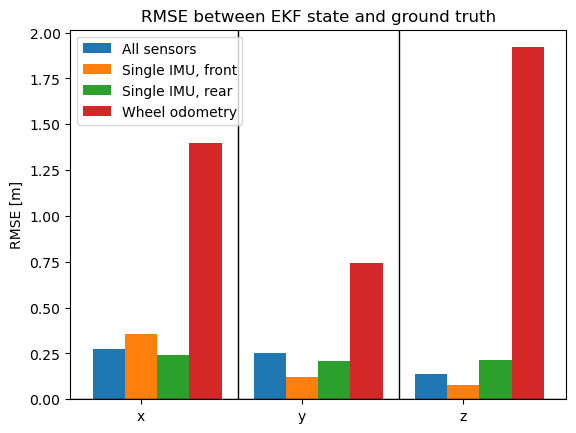

In [8]:
# Calculate the root mean squared error between full ekf and gt
rmse_full = np.sqrt(np.mean(np.square(dist), axis=0))
rmse_single = np.sqrt(np.mean(np.square(dist_single), axis=0))
rmse_single_rear = np.sqrt(np.mean(np.square(dist_single_rear), axis=0))
rmse_odom = np.sqrt(np.mean(np.square(dist_odom), axis=0))

print("RMSE full ekf: ", rmse_full)
print("RMSE single imu: ", rmse_single)
print("RMSE single imu rear: ", rmse_single_rear)
print("RMSE wheel twist: ", rmse_odom)

# Calculate the mean error between full ekf and gt
mean_full = np.mean(dist, axis=0)
mean_single = np.mean(dist_single, axis=0)
mean_single_rear = np.mean(dist_single_rear, axis=0)
mean_odom = np.mean(dist_odom, axis=0)

print("Mean full ekf: ", mean_full)
print("Mean single imu: ", mean_single)
print("Mean single imu rear: ", mean_single_rear)
print("Mean wheel twist: ", mean_odom)

# create a bar plot of the mean error
fig, ax = plt.subplots(1,1)
width = 0.2
ax.bar(np.arange(3), mean_full, width, label="All sensors")
ax.bar(np.arange(3) + width, mean_single, width, label="Single IMU, front")
ax.bar(np.arange(3) + 2*width, mean_single_rear, width, label="Single IMU, rear")
ax.bar(np.arange(3) + 3*width, mean_odom, width, label="Wheel odometry")
ax.set_xticks(np.arange(3) + width)
ax.set_xticklabels(["x", "y", "z"])
ax.set_ylabel("Mean error [m]")
ax.set_title("Mean error between EKF state and ground truth")
ax.legend()
# Create separation line between the x ticks offsetted by width
ax.axvline(4*width, color="black", linewidth=1)
ax.axvline(9*width, color="black", linewidth=1)
ax.axhline(0, color="black", linewidth=1)

plt.savefig("/home/daniel/Documents/master/billeder/odom_ekf_mean_error.png", dpi=300)

plt.show()


# create a bar plot of the rmse
fig, ax = plt.subplots(1,1)
width = 0.2
ax.bar(np.arange(3), rmse_full, width, label="All sensors")
ax.bar(np.arange(3) + width, rmse_single, width, label="Single IMU, front")
ax.bar(np.arange(3) + 2*width, rmse_single_rear, width, label="Single IMU, rear")
ax.bar(np.arange(3) + 3*width, rmse_odom, width, label="Wheel odometry")
ax.set_xticks(np.arange(3) + width)
ax.set_xticklabels(["x", "y", "z"])
ax.set_ylabel("RMSE [m]")
ax.set_title("RMSE between EKF state and ground truth")
ax.legend()
# Create separation line between the x ticks offsetted by width
ax.axvline(4*width, color="black", linewidth=1)
ax.axvline(9*width, color="black", linewidth=1)
ax.axhline(0, color="black", linewidth=1)


plt.savefig("/home/daniel/Documents/master/billeder/odom_ekf_rmse_error.png", dpi=300)




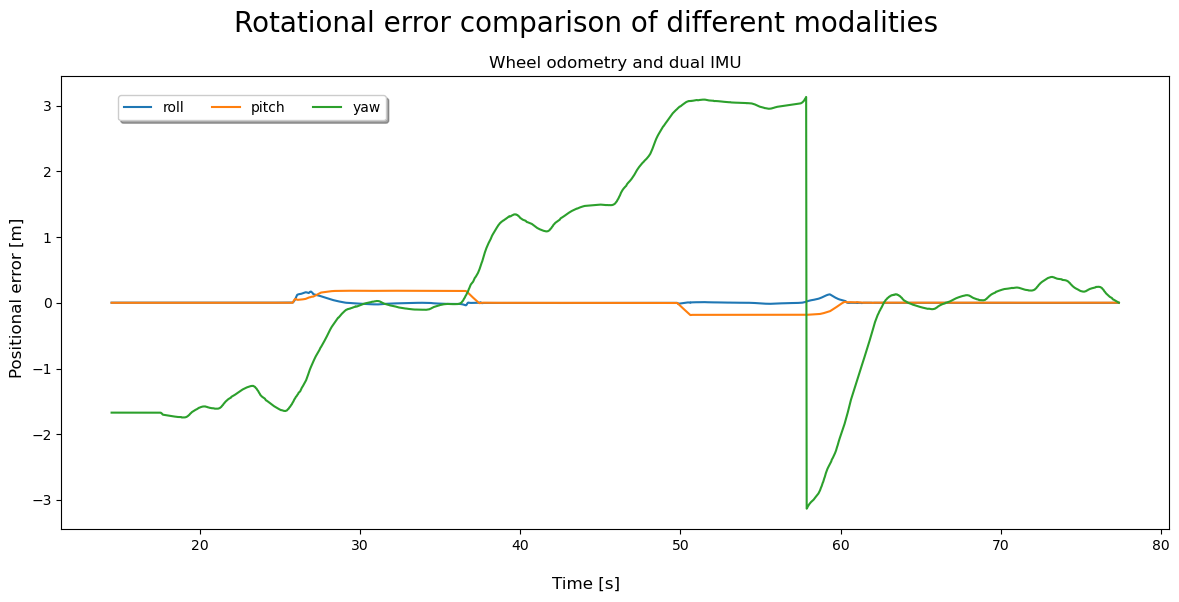

In [19]:
gt_positions = np.array(base_gt["positions"])
# loc_positions = np.array(localization_dict["positions"])
dist = np.empty((0,3))

gt_rpy = base_gt["orientations"][idx].as_euler('xyz', degrees=False)

angular_difference = []
for i in range(base_ekf_full_pose.shape[0]):

    loc_rpy = base_ekf_full["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference_full = np.array(angular_difference)



angular_difference = []
for i in range(base_ekf_single_imu_pose.shape[0]):

    loc_rpy = base_ekf_single_imu["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference_single = np.array(angular_difference)

angular_difference = []
for i in range(base_ekf_single_imu_rear_pose.shape[0]):

    loc_rpy = base_ekf_single_imu_rear["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference_single_rear = np.array(angular_difference)

angular_difference = []
for i in range(base_ekf_odom_pose.shape[0]):

    loc_rpy = base_ekf_odom["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference_odom = np.array(angular_difference)


fig, ax = plt.subplots(1)

# Plot distance vs time 

ax.plot(base_ekf_full["timesteps"], angular_difference_full[:,0], label="roll")
ax.plot(base_ekf_full["timesteps"], angular_difference_full[:,1], label="pitch")
ax.plot(base_ekf_full["timesteps"], angular_difference_full[:,2], label="yaw")
ax.set_title("Wheel odometry and dual IMU", loc="center")
# ax[1,1].set_ylim([-0.8, 0.6])

# ax[0,0].plot(base_ekf_single_imu["timesteps"], angular_difference_single[:,0], label="roll")
# ax[0,0].plot(base_ekf_single_imu["timesteps"], angular_difference_single[:,1], label="pitch")
# ax[0,0].plot(base_ekf_single_imu["timesteps"], angular_difference_single[:,2], label="yaw")
# ax[0,0].set_title("Wheel odometry and single IMU, front", loc="center")
# # ax[0,0].set_ylim([-0.8, 0.6])


# ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], angular_difference_single_rear[:,0], label="roll")
# ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], angular_difference_single_rear[:,1], label="pitch")
# ax[0,1].plot(base_ekf_single_imu_rear["timesteps"], angular_difference_single_rear[:,2], label="yaw")
# ax[0,1].set_title("Wheel odometry and single IMU, rear", loc="center")
# # ax[0,1].set_ylim([-0.8, 0.6])

# ax[1,0].plot(base_ekf_odom["timesteps"], angular_difference_odom[:,0], label="roll")
# ax[1,0].plot(base_ekf_odom["timesteps"], angular_difference_odom[:,1], label="pitch")
# ax[1,0].plot(base_ekf_odom["timesteps"], angular_difference_odom[:,2], label="yaw")
# ax[1,0].set_title("Wheel odometry", loc="center")


# Set width and height of plot
width = 12
height = 6
fig.set_figwidth(width)
fig.set_figheight(height)

# # Plot angular difference vs time
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,0], label="roll")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,1], label="pitch")
# ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,2], label="yaw")

# Vertically align y labels on plot 0 and 1
# fig.align_ylabels()

# Place legend horizontally
# ax[0,0].legend(, ncol=3, fancybox=True, shadow=True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.1, 0.8), ncol=3, fancybox=True, shadow=True)

fig.supylabel("Positional error [m]")
fig.subplots_adjust(hspace=0.2, wspace=0.2)
fig.supxlabel("Time [s]")
fig.suptitle("Rotational error comparison of different modalities", fontsize=20)

# change margin between supxlabel, supylabel and subplots
plt.tight_layout()

(1, 3790)
(1, 1888)


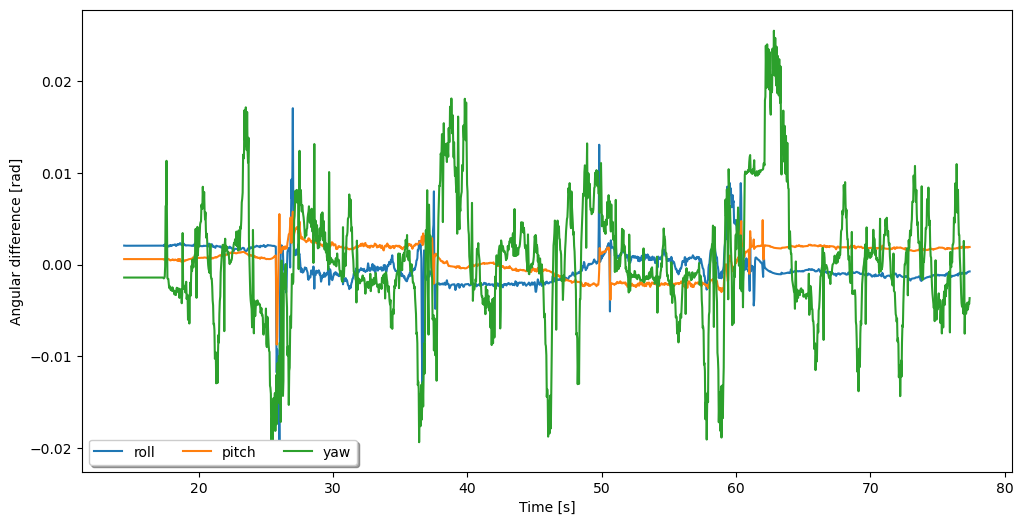

In [27]:
gt_rpy= np.empty((0,3))

ang_diff = np.empty((0,3))

print(np.array([base_gt["orientations"]]).shape)
print(np.array([base_ekf_full["orientations"]]).shape)

for i, pos in enumerate(base_ekf_full_pose):

    
    # find closest timestep in gt 
    idx = np.argmin(np.abs(np.array(base_gt["timesteps"]) - base_ekf_full["timesteps"][i]))

    #print(gt_positions[idx] - pos)
    dist = np.vstack((dist, (gt_positions[idx] - pos)))
    # Calculate difference in roll, pitch and yaw between gt and localization
    # print(base_gt["orientations"][idx].as_euler('xyz', degrees=False), base_ekf_full["orientations"][i])
    gt_rpy = base_gt["orientations"][idx].as_euler('xyz', degrees=False)
    loc_rpy = base_ekf_full["orientations"][i].as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    ang_diff = np.vstack((ang_diff, [roll_diff, pitch_diff, yaw_diff]))

for i in range(1, np.array([ang_diff]).shape[0]):
    if np.abs(ang_diff[i,2]  - ang_diff[i-1, 2]) > np.pi:
        ang_diff[i-1,2] = np.NaN
# gt_rpy = base_gt["orientations"].as_euler('xyz', degrees=False)
# Plot gt roll, pitch and yaw in a single plot
plt.plot(base_ekf_full["timesteps"], ang_diff[:,0], label="roll")
plt.plot(base_ekf_full["timesteps"], ang_diff[:,1], label="pitch")
plt.plot(base_ekf_full["timesteps"], ang_diff[:,2], label="yaw")
plt.legend(loc='lower left', ncol=3, fancybox=True, shadow=True)
plt.xlabel("Time [s]")
plt.ylabel("Angular difference [rad]")
plt.gcf().set_figwidth(width)
plt.gcf().set_figheight(height)
plt.show()

In [28]:
# calculate rmse of angular difference
rmse_ang = np.sqrt(np.nanmean(np.square(ang_diff), axis=0))
print("RMSE angular difference: ", rmse_ang)

# calculate mean of angular difference
mean_ang = np.nanmean(ang_diff, axis=0)
print("Mean angular difference: ", mean_ang)


RMSE angular difference:  [0.00208899 0.00175906 0.00654866]
Mean angular difference:  [-0.00018287  0.00063901  0.00034464]


In [ ]:
# Load times from test_data/times.txt
times = np.zeros((8,8))
times[0, :] = [np.nan, 50, 100, 200, 400, 800, 1600, 3200]
times[1:, 0] = [50, 100, 200, 400, 800, 1600, 3200]
with open("/home/junge/master_ws/src/Danitech-master/lmao/lmao/test_data/times.txt", "r") as f:
    # "Time for x rays and y particles: z"
    for line in f:
        line = line.split()
        x = int(line[2])
        x = times[:,0].tolist().index(x)
        y = int(line[5])
        y = times[0,:].tolist().index(y)
        times[x,y] = float(line[7])
    print("0th index is x rays, 0th element is y particles")
times = np.array(times)

# Plot times as a line
plt.plot(times[0, 1:], times[1:, 1:])
plt.xlabel("Number of particles")
plt.ylabel("Time [s]")
plt.legend(["50 rays", "100 rays", "200 rays", "400 rays", "800 rays", "1600 rays", "3200 rays"])
# set y log scale
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/home/junge/master_ws/src/Danitech-master/lmao/lmao/test_data/times.txt'